In [1]:
#import all the required libraries
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [2]:
#read data
datetime_cols = ['sched_1_355','sched_2_1035', 'sched_3_418', 
 'sched_4_2543', 'stop_1_355', 'stop_2_1035', 
  'stop_3_418', 'stop_4_2543']
path = r"https://raw.githubusercontent.com/mic00s/Summer-School-2023/%D1%87%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%B0/raw%20data/bus_data_w_iso_dates_and_delta_times.csv"
var_data=pd.read_csv(filepath_or_buffer=path, parse_dates=datetime_cols)

var_data.head(10)

,course_id,sched_1_355,sched_2_1035,sched_3_418,sched_4_2543,stop_1_355,stop_2_1035,stop_3_418,stop_4_2543,stay_1_355,...,t_stop2_to_stop3,t_stop3_to_stop4,sched_1_355_s,sched_2_1035_s,sched_3_418_s,sched_4_2543_s,stop_1_355_s,stop_2_1035_s,stop_3_418_s,stop_4_2543_s
0,1143527,2020-01-10 05:30:29.664,2020-01-10 05:31:30.144,2020-01-10 05:33:30.240,2020-01-10 05:35:30.336,2020-01-10 05:29:30.048,2020-01-10 05:30:29.664,2020-01-10 05:31:44.832,2020-01-10 05:34:36.768,0.0,...,75.168,171.936,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09
1,1143529,2020-01-10 06:42:29.664,2020-01-10 06:43:30.144,2020-01-10 06:45:30.240,2020-01-10 06:47:30.336,2020-01-10 06:41:43.872,2020-01-10 06:43:09.408,2020-01-10 06:44:33.216,2020-01-10 06:48:02.304,1.0,...,83.808,209.088,1.578631e+09,1.578631e+09,1.578632e+09,1.578632e+09,1.578631e+09,1.578631e+09,1.578631e+09,1.578632e+09
2,1143531,2020-01-10 07:44:30.048,2020-01-10 07:46:30.144,2020-01-10 07:48:30.240,2020-01-10 07:51:29.952,2020-01-10 07:45:08.064,2020-01-10 07:47:33.216,2020-01-10 07:48:59.616,2020-01-10 07:52:07.968,1.0,...,86.400,188.352,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578636e+09
3,1143533,2020-01-10 08:58:30.144,2020-01-10 09:00:30.240,2020-01-10 09:02:30.336,2020-01-10 09:05:30.048,2020-01-10 08:58:30.144,2020-01-10 09:00:19.008,2020-01-10 09:01:31.584,2020-01-10 09:04:40.800,0.0,...,72.576,189.216,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09
4,1143535,2020-01-10 10:28:30.144,2020-01-10 10:30:30.240,2020-01-10 10:32:30.336,2020-01-10 10:35:30.048,2020-01-10 10:27:38.304,2020-01-10 10:30:02.592,2020-01-10 10:31:36.768,2020-01-10 10:34:37.344,2.0,...,94.176,180.576,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09
5,1143539,2020-01-10 12:50:30.048,2020-01-10 12:52:30.144,2020-01-10 12:54:30.240,2020-01-10 12:57:29.952,2020-01-10 12:50:09.312,2020-01-10 12:51:59.904,2020-01-10 12:54:10.368,2020-01-10 12:56:40.704,1.0,...,130.464,150.336,1.578653e+09,1.578654e+09,1.578654e+09,1.578654e+09,1.578653e+09,1.578654e+09,1.578654e+09,1.578654e+09
6,1143543,2020-01-10 15:12:29.952,2020-01-10 15:14:30.048,2020-01-10 15:16:30.144,2020-01-10 15:19:29.856,2020-01-10 15:12:15.264,2020-01-10 15:14:16.224,2020-01-10 15:15:47.808,2020-01-10 15:19:41.088,0.5,...,91.584,233.280,1.578662e+09,1.578662e+09,1.578662e+09,1.578662e+09,1.578662e+09,1.578662e+09,1.578662e+09,1.578662e+09
7,1143545,2020-01-10 16:29:29.760,2020-01-10 16:31:29.856,2020-01-10 16:33:29.952,2020-01-10 16:36:29.664,2020-01-10 16:30:30.240,2020-01-10 16:32:40.704,2020-01-10 16:33:50.688,2020-01-10 16:36:14.112,1.0,...,69.984,143.424,1.578667e+09,1.578667e+09,1.578667e+09,1.578667e+09,1.578667e+09,1.578667e+09,1.578667e+09,1.578667e+09
8,1143547,2020-01-10 17:41:29.760,2020-01-10 17:43:29.856,2020-01-10 17:45:29.952,2020-01-10 17:48:29.664,2020-01-10 17:49:11.136,2020-01-10 17:50:45.312,2020-01-10 17:54:04.032,2020-01-10 17:59:43.584,1.0,...,198.720,339.552,1.578671e+09,1.578671e+09,1.578671e+09,1.578671e+09,1.578671e+09,1.578671e+09,1.578672e+09,1.578672e+09
9,1143549,2020-01-10 18:52:30.144,2020-01-10 18:54:30.240,2020-01-10 18:56:30.336,2020-01-10 18:59:30.048,2020-01-10 19:05:50.208,2020-01-10 19:07:32.160,2020-01-10 19:08:41.280,2020-01-10 19:12:10.368,1.0,...,69.120,209.088,1.578675e+09,1.578675e+09,1.578675e+09,1.578676e+09,1.578676e+09,1.578676e+09,1.578676e+09,1.578676e+09


In [3]:
var_data.dtypes


course_id                    int64
sched_1_355         datetime64[ns]
sched_2_1035        datetime64[ns]
sched_3_418         datetime64[ns]
sched_4_2543        datetime64[ns]
stop_1_355          datetime64[ns]
stop_2_1035         datetime64[ns]
stop_3_418          datetime64[ns]
stop_4_2543         datetime64[ns]
stay_1_355                 float64
stay_2_1035                float64
stay_3_418                 float64
stay_4_2543                float64
daily_course                 int64
weekly_course                int64
t_stop1_to_stop2           float64
t_stop2_to_stop3           float64
t_stop3_to_stop4           float64
sched_1_355_s              float64
sched_2_1035_s             float64
sched_3_418_s              float64
sched_4_2543_s             float64
stop_1_355_s               float64
stop_2_1035_s              float64
stop_3_418_s               float64
stop_4_2543_s              float64
dtype: object

In [4]:
#check missing values
var_data.isnull().sum()

course_id           0
sched_1_355         0
sched_2_1035        0
sched_3_418         0
sched_4_2543        0
stop_1_355          0
stop_2_1035         0
stop_3_418          0
stop_4_2543         0
stay_1_355          0
stay_2_1035         0
stay_3_418          0
stay_4_2543         0
daily_course        0
weekly_course       0
t_stop1_to_stop2    0
t_stop2_to_stop3    0
t_stop3_to_stop4    0
sched_1_355_s       0
sched_2_1035_s      0
sched_3_418_s       0
sched_4_2543_s      0
stop_1_355_s        0
stop_2_1035_s       0
stop_3_418_s        0
stop_4_2543_s       0
dtype: int64

In [21]:
var_data['sched_1_355'] = pd.to_datetime(var_data.sched_1_355 , format = '%d/%m/%Y %H.%M.%S')
var_data1 = var_data.drop(['sched_1_355'], axis=1)

var_data1['day'] = var_data['sched_1_355'].dt.day

var_data1['year'] = var_data['sched_1_355'].dt.year
var_data1['month'] = var_data['sched_1_355'].dt.month

#var_data1.index = var_data.sched_1_355
var_data1.index = var_data1.month
var_data1.head()

,course_id,sched_2_1035,sched_3_418,sched_4_2543,stop_1_355,stop_2_1035,stop_3_418,stop_4_2543,stay_1_355,stay_2_1035,...,sched_2_1035_s,sched_3_418_s,sched_4_2543_s,stop_1_355_s,stop_2_1035_s,stop_3_418_s,stop_4_2543_s,day,year,month
month,,,,,,,,,,,,,,,,,,,,,
1,1143527,2020-01-10 05:31:30.144,2020-01-10 05:33:30.240,2020-01-10 05:35:30.336,2020-01-10 05:29:30.048,2020-01-10 05:30:29.664,2020-01-10 05:31:44.832,2020-01-10 05:34:36.768,0.0,0.0,...,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,1.578627e+09,10,2020,1
1,1143529,2020-01-10 06:43:30.144,2020-01-10 06:45:30.240,2020-01-10 06:47:30.336,2020-01-10 06:41:43.872,2020-01-10 06:43:09.408,2020-01-10 06:44:33.216,2020-01-10 06:48:02.304,1.0,1.0,...,1.578631e+09,1.578632e+09,1.578632e+09,1.578631e+09,1.578631e+09,1.578631e+09,1.578632e+09,10,2020,1
1,1143531,2020-01-10 07:46:30.144,2020-01-10 07:48:30.240,2020-01-10 07:51:29.952,2020-01-10 07:45:08.064,2020-01-10 07:47:33.216,2020-01-10 07:48:59.616,2020-01-10 07:52:07.968,1.0,1.0,...,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578635e+09,1.578636e+09,10,2020,1
1,1143533,2020-01-10 09:00:30.240,2020-01-10 09:02:30.336,2020-01-10 09:05:30.048,2020-01-10 08:58:30.144,2020-01-10 09:00:19.008,2020-01-10 09:01:31.584,2020-01-10 09:04:40.800,0.0,0.0,...,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,1.578640e+09,10,2020,1
1,1143535,2020-01-10 10:30:30.240,2020-01-10 10:32:30.336,2020-01-10 10:35:30.048,2020-01-10 10:27:38.304,2020-01-10 10:30:02.592,2020-01-10 10:31:36.768,2020-01-10 10:34:37.344,2.0,1.0,...,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,1.578645e+09,10,2020,1


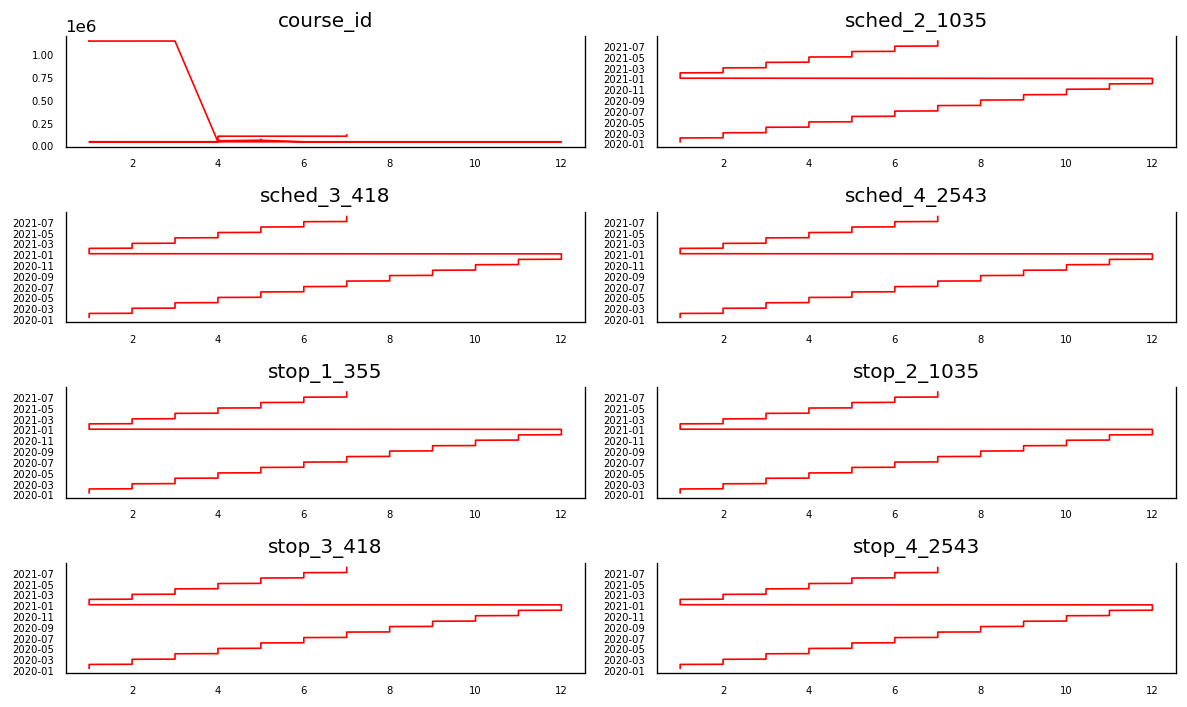

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

#columns_to_plot = ['t_stop1_to_stop2', 't_stop2_to_stop3', 't_stop3_to_stop4', 'daily_course', 'stay_1_355', 'stop_2_1035', 'stop_3_418', 'stay_4_2543']
#col_name = var_data1.columns[i]

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))

#for i, (col_name, ax) in enumerate(zip(columns_to_plot,axes.flatten())):
   # data = var_data1.columns[i]
   # ax.plot(data, color='red', linewidth=1)
    # Decorations
    #ax.set_title(var_data1.columns[i])
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    #ax.spines["top"].set_alpha(0)
    #ax.tick_params(labelsize=6)

#plt.tight_layout();



for i, ax in enumerate(axes.flatten()):
    data = var_data1[var_data1.columns[i]]
    ax.plot(data, color='red', linewidth=1)
     #Decorations
    ax.set_title(var_data1.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
###missing value treatment
#cols = var_data1.columns
#for j in cols:
#Chapter 3 Advanced Univariate and Statistical Multivariate Modeling
#for i in range(0,len(var_data1)):
#if var_data1[j][i] == -200:
#var_data1[j][i] = var_data1[j][i-1]



In [50]:
ad_fuller_result_1 = adfuller(var_data1['t_stop1_to_stop2'][1:])

print('realdelta')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(var_data1['t_stop2_to_stop3'][1:])

print('realdelta2')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(var_data1['t_stop3_to_stop4'][1:])

print('realdelta3')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

realdelta
ADF Statistic: -3.6371488527131275
p-value: 0.005089272194738913

---------------------

realdelta2
ADF Statistic: -15.279724272751642
p-value: 4.595543110483416e-28

---------------------



KeyError: 't_stop3_to_stop4'

In [45]:
##Granger Causality

print('time delta 1 causes time delta 2?\n')
print('------------------')
granger_1 = grangercausalitytests(var_data1[['t_stop1_to_stop2', 't_stop2_to_stop3']], 4)

print('\time delta 2 causes time delta 1?\n')
print('------------------')
granger_2 = grangercausalitytests(var_data1[['t_stop2_to_stop3', 't_stop1_to_stop2']], 4)

time delta 1 causes time delta 2?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=118.8925, p=0.0000  , df_denom=7388, df_num=1
ssr based chi2 test:   chi2=118.9408, p=0.0000  , df=1
likelihood ratio test: chi2=117.9939, p=0.0000  , df=1
parameter F test:         F=118.8925, p=0.0000  , df_denom=7388, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=38.7869 , p=0.0000  , df_denom=7385, df_num=2
ssr based chi2 test:   chi2=77.6263 , p=0.0000  , df=2
likelihood ratio test: chi2=77.2214 , p=0.0000  , df=2
parameter F test:         F=38.7869 , p=0.0000  , df_denom=7385, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=31.8099 , p=0.0000  , df_denom=7382, df_num=3
ssr based chi2 test:   chi2=95.5202 , p=0.0000  , df=3
likelihood ratio test: chi2=94.9081 , p=0.0000  , df=3
parameter F test:         F=31.8099 , p=0.0000  , df_denom=7382, df_num=3

Granger Causality
number of lags 

In [51]:


var_data1 = var_data1[['t_stop1_to_stop2','t_stop2_to_stop3']]
print(var_data1.shape)
     


(7392, 2)


In [52]:
train_df=var_data1[:7202]
test_df=var_data1[7202:]

In [53]:
print(test_df.shape)

(190, 2)


In [54]:
model = VAR(train_df.diff()[1:])

In [55]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.94       14.94   3.068e+06       14.94
1        14.50       14.51   1.983e+06       14.50
2        14.34       14.35   1.685e+06       14.34
3        14.25       14.27   1.550e+06       14.26
4        14.20       14.22   1.475e+06       14.21
5        14.17       14.19   1.425e+06       14.18
6        14.14       14.16   1.378e+06       14.15
7        14.11       14.14   1.348e+06       14.12
8        14.09       14.12   1.314e+06       14.10
9        14.05       14.09   1.268e+06       14.07
10       14.02       14.06   1.229e+06       14.04
11       13.99       14.04   1.194e+06       14.01
12       13.97       14.02   1.167e+06       13.99
13       13.95       14.00   1.144e+06       13.97
14       13.94      14.00*   1.135e+06       13.96
15       13.94       14.00   1.132e+06       13.96
16       13.94       14.00   1.

In [56]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['t_stop1_to_stop2', 't_stop2_to_stop3']   No. Observations:                 7202
Model:                                               VAR(4)   Log Likelihood              -71079.186
                                                + intercept   AIC                         142200.371
Date:                                      Fri, 21 Jul 2023   BIC                         142344.895
Time:                                              23:04:35   HQIC                        142250.101
Sample:                                                   0                                         
                                                     - 7202                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             1.84, 0.09   Jarque-Bera (JB):    1736.68, 74638.79
Prob(Q)

In [64]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [65]:
predictions.columns=['t_stop1_to_stop2_predicted','t_stop2_to_stop3_predicted']
predictions

,t_stop1_to_stop2_predicted,t_stop2_to_stop3_predicted
7202,111.075412,76.731421
7203,104.647670,79.439970
7204,106.752242,79.521810
7205,109.609642,77.982893
7206,105.774942,79.702100
7207,104.718805,79.981071
7208,104.549827,80.012010
7209,104.192759,80.007936
7210,103.318769,80.260358
7211,102.883717,80.312661


In [67]:
test_vs_pred = pd.concat([test_df,predictions],axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [70]:
predictions.shape


(12, 2)

In [66]:
test_vs_pred.plot(figsize=(190,12))

NameError: name 'test_vs_pred' is not defined

In [74]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

delta = var_data1['t_stop1_to_stop2']

rmse = np.sqrt(mean_squared_error(test_df[delta], predictions))
mae  = mean_absolute_error(test_df[delta], predictions)
mape = mean_absolute_percentage_error(test_df[delta], predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

#rmse_stop1_2 =math.sqrt(mean_squared_error(predictions['t_stop1_to_stop2_predicted'],test_df['t_stop1_to_stop2']))
#print('Mean value of t_stop1_to_stop2 is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['t_stop1_to_stop2']),rmse_stop1_2))


#rmse_stop2_3 =math.sqrt(mean_squared_error(predictions['t_stop2_to_stop3_predicted'],test_df['t_stop2_to_stop3']))
#print('Mean value of t_stop2_to_stop3 is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['t_stop2_to_stop3']),rmse_stop2_3))

KeyError: "None of [Float64Index([ 59.616,  85.536, 145.152, 108.864, 144.288, 110.592,  120.96,\n              130.464,  94.176, 101.952,\n              ...\n              114.048,  92.448, 114.912, 127.008,    86.4,   151.2,  80.352,\n               83.808, 109.728, 128.736],\n             dtype='float64', length=7392)] are in the [columns]"

In [73]:

test_df['t_stop1_to_stop2'].shape


(190,)

In [9]:
# Example Timedelta object
#td = pd.Timedelta(days=1, hours=2, minutes=30)

# Extract the total number of seconds and convert to float
#seconds = td.total_seconds()
#float_value = float(seconds)

#print(float_value)


import pandas as pd

# Example DataFrame with a Timedelta column
df = pd.DataFrame({'duration': [pd.Timedelta(days=1, hours=2, minutes=30),
                                pd.Timedelta(hours=3, minutes=15)]})

# Extract the total number of seconds and convert to float
df['duration'] = df['duration'].apply(lambda x: x.total_seconds()).astype(float)

print(df)

In this updated exampl

SyntaxError: invalid syntax (1962433405.py, line 22)

In [6]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#'sched_1_355_s','sched_2_1035_s','sched_3_418_s','sched_4_2543_s'
#'weekly_course',

#'stay_1_355','stay_4_2543','stay_2_1035', 'stay_3_418'
#'t_stop1_to_stop2', 't_stop2_to_stop3', 't_stop3_to_stop4',
#'stop_1_355_s','stop_2_1035_s','stop_3_418_s','stop_4_2543_s'
#'sched_2_1035', 'sched_3_418','sched_4_2543','stop_1_355','stop_2_1035','stop_3_418', 'stop_4_2543', 'course_id',
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
test = var_data1.drop(['daily_course','weekly_course',
                      't_stop1_to_stop2', 't_stop2_to_stop3', 't_stop3_to_stop4'], axis=1)
coint_johansen(test,-1,1).eig

C:\Users\4o4o\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:648: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn(


TypeError: float() argument must be a string or a real number, not 'Timedelta'

In [8]:
### Beginner Data Science Machine Learning Python Time Series Forecasting

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(var_data['t_stop1_to_stop2'])

Augmented Dickey-Fuller Test: 


NameError: name 'adfuller' is not defined

In [8]:
#creating the train and validation set
train_data = var_data1[:int(0.8*(len(var_data1)))]
valid_data = var_data1[int(0.8*(len(var_data1))):]

In [27]:
##fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
var_model = VAR(endog=train_data)
var_model_fit = var_model.fit()
# make prediction on validation
pred = var_model_fit.forecast(var_model_fit.endog, steps=len(valid_data))
pred

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen werecourse_id                    int64
sched_2_1035        datetime64[ns]
sched_3_418         datetime64[ns]
sched_4_2543        datetime64[ns]
stop_1_355          datetime64[ns]
stop_2_1035         datetime64[ns]
stop_3_418          datetime64[ns]
stop_4_2543         datetime64[ns]
stay_1_355                 float64
stay_2_1035                float64
stay_3_418                 float64
stay_4_2543                float64
daily_course                 int64
weekly_course                int64
t_stop1_to_stop2           float64
t_stop2_to_stop3           float64
t_stop3_to_stop4           float64
sched_1_355_s              float64
sched_2_1035_s             float64
sched_3_418_s              float64
sched_4_2543_s             float64
stop_1_355_s               float64
stop_2_1035_s              float64
stop_3_418_s               float64
stop_4_2543_s              float64
dtype: object and None. The data was
                         course_id            sched_2_1035  \
sched_1_355                                                  
2020-01-10 05:30:29.664    1143527 2020-01-10 05:31:30.144   
2020-01-10 06:42:29.664    1143529 2020-01-10 06:43:30.144   
2020-01-10 07:44:30.048    1143531 2020-01-10 07:46:30.144   
2020-01-10 08:58:30.144    1143533 2020-01-10 09:00:30.240   
2020-01-10 10:28:30.144    1143535 2020-01-10 10:30:30.240   
...                            ...                     ...   
2021-04-06 06:42:29.664      39961 2021-04-06 06:43:30.144   
2021-04-06 07:44:30.048      39963 2021-04-06 07:46:30.144   
2021-04-06 08:58:30.144      39965 2021-04-06 09:00:30.240   
2021-04-06 10:28:30.144      39967 2021-04-06 10:30:30.240   
2021-04-06 11:39:29.664      39969 2021-04-06 11:41:29.760   

                                    sched_3_418            sched_4_2543  \
sched_1_355                                                               
2020-01-10 05:30:29.664 2020-01-10 05:33:30.240 2020-01-10 05:35:30.336   
2020-01-10 06:42:29.664 2020-01-10 06:45:30.240 2020-01-10 06:47:30.336   
2020-01-10 07:44:30.048 2020-01-10 07:48:30.240 2020-01-10 07:51:29.952   
2020-01-10 08:58:30.144 2020-01-10 09:02:30.336 2020-01-10 09:05:30.048   
2020-01-10 10:28:30.144 2020-01-10 10:32:30.336 2020-01-10 10:35:30.048   
...                                         ...                     ...   
2021-04-06 06:42:29.664 2021-04-06 06:45:30.240 2021-04-06 06:47:30.336   
2021-04-06 07:44:30.048 2021-04-06 07:48:30.240 2021-04-06 07:51:29.952   
2021-04-06 08:58:30.144 2021-04-06 09:02:30.336 2021-04-06 09:05:30.048   
2021-04-06 10:28:30.144 2021-04-06 10:32:30.336 2021-04-06 10:35:30.048   
2021-04-06 11:39:29.664 2021-04-06 11:43:29.856 2021-04-06 11:46:30.432   

                                     stop_1_355             stop_2_1035  \
sched_1_355                                                               
2020-01-10 05:30:29.664 2020-01-10 05:29:30.048 2020-01-10 05:30:29.664   
2020-01-10 06:42:29.664 2020-01-10 06:41:43.872 2020-01-10 06:43:09.408   
2020-01-10 07:44:30.048 2020-01-10 07:45:08.064 2020-01-10 07:47:33.216   
2020-01-10 08:58:30.144 2020-01-10 08:58:30.144 2020-01-10 09:00:19.008   
2020-01-10 10:28:30.144 2020-01-10 10:27:38.304 2020-01-10 10:30:02.592   
...                                         ...                     ...   
2021-04-06 06:42:29.664 2021-04-06 06:41:35.232 2021-04-06 06:42:58.176   
2021-04-06 07:44:30.048 2021-04-06 07:43:34.752 2021-04-06 07:45:33.984   
2021-04-06 08:58:30.144 2021-04-06 08:57:55.584 2021-04-06 09:00:06.912   
2021-04-06 10:28:30.144 2021-04-06 10:28:01.632 2021-04-06 10:30:00.000   
2021-04-06 11:39:29.664 2021-04-06 11:38:30.912 2021-04-06 11:41:03.840   

                                     stop_3_418             stop_4_2543  \
sched_1_355                                                               
2020-01-10 05:30:29.664 2020-01-10 05:31:44.832 2020-01-10 05:34:36.768   
2020-01-10 06:42:29.664 2020-01-10 06:44:33.216 2020-01-10 06:48:02.304   
2020-01-10 07:44:30.048 2020-01-10 07:48:59.616 2020-01-10 07:52:07.968   
2020-01-10 08:58:30.144 2020-01-10 09:01:31.584 2020-01-10 09:04:40.800   
2020-01-10 10:28:30.144 2020-01-10 10:31:36.768 2020-01-10 10:34:37.344   
...                                         ...                     ...   
2021-04-06 06:42:29.664 2021-04-06 06:44:06.432 2021-04-06 06:46:30.720   
2021-04-06 07:44:30.048 2021-04-06 07:46:36.192 2021-04-06 07:50:30.336   
2021-04-06 08:58:30.144 2021-04-06 09:01:52.320 2021-04-06 09:05:56.832   
2021-04-06 10:28:30.144 2021-04-06 10:31:43.680 2021-04-06 10:34:31.296   
2021-04-06 11:39:29.664 2021-04-06 11:43:10.848 2021-04-06 11:48:06.336   

                         stay_1_355  stay_2_1035  ...  t_stop2_to_stop3  \
sched_1_355                                       ...                     
2020-01-10 05:30:29.664         0.0          0.0  ...            75.168   
2020-01-10 06:42:29.664         1.0          1.0  ...            83.808   
2020-01-10 07:44:30.048         1.0          1.0  ...            86.400   
2020-01-10 08:58:30.144         0.0          0.0  ...            72.576   
2020-01-10 10:28:30.144         2.0          1.0  ...            94.176   
...                             ...          ...  ...               ...   
2021-04-06 06:42:29.664         1.0          0.0  ...            68.256   
2021-04-06 07:44:30.048         0.0          1.0  ...            62.208   
2021-04-06 08:58:30.144         1.0          1.0  ...           105.408   
2021-04-06 10:28:30.144         1.0          1.0  ...           103.680   
2021-04-06 11:39:29.664         1.0          1.0  ...           127.008   

                         t_stop3_to_stop4  sched_1_355_s  sched_2_1035_s  \
sched_1_355                                                                
2020-01-10 05:30:29.664           171.936   1.578627e+09    1.578627e+09   
2020-01-10 06:42:29.664           209.088   1.578631e+09    1.578631e+09   
2020-01-10 07:44:30.048           188.352   1.578635e+09    1.578635e+09   
2020-01-10 08:58:30.144           189.216   1.578640e+09    1.578640e+09   
2020-01-10 10:28:30.144           180.576   1.578645e+09    1.578645e+09   
...                                   ...            ...             ...   
2021-04-06 06:42:29.664           144.288   1.617684e+09    1.617684e+09   
2021-04-06 07:44:30.048           234.144   1.617688e+09    1.617688e+09   
2021-04-06 08:58:30.144           244.512   1.617692e+09    1.617692e+09   
2021-04-06 10:28:30.144           167.616   1.617698e+09    1.617698e+09   
2021-04-06 11:39:29.664           295.488   1.617702e+09    1.617702e+09   

                         sched_3_418_s  sched_4_2543_s  stop_1_355_s  \
sched_1_355                                                            
2020-01-10 05:30:29.664   1.578627e+09    1.578627e+09  1.578627e+09   
2020-01-10 06:42:29.664   1.578632e+09    1.578632e+09  1.578631e+09   
2020-01-10 07:44:30.048   1.578635e+09    1.578635e+09  1.578635e+09   
2020-01-10 08:58:30.144   1.578640e+09    1.578640e+09  1.578640e+09   
2020-01-10 10:28:30.144   1.578645e+09    1.578645e+09  1.578645e+09   
...                                ...             ...           ...   
2021-04-06 06:42:29.664   1.617684e+09    1.617684e+09  1.617684e+09   
2021-04-06 07:44:30.048   1.617688e+09    1.617688e+09  1.617688e+09   
2021-04-06 08:58:30.144   1.617693e+09    1.617693e+09  1.617692e+09   
2021-04-06 10:28:30.144   1.617698e+09    1.617698e+09  1.617698e+09   
2021-04-06 11:39:29.664   1.617702e+09    1.617702e+09  1.617702e+09   

                         stop_2_1035_s  stop_3_418_s  stop_4_2543_s  
sched_1_355                                                          
2020-01-10 05:30:29.664   1.578627e+09  1.578627e+09   1.578627e+09  
2020-01-10 06:42:29.664   1.578631e+09  1.578631e+09   1.578632e+09  
2020-01-10 07:44:30.048   1.578635e+09  1.578635e+09   1.578636e+09  
2020-01-10 08:58:30.144   1.578640e+09  1.578640e+09   1.578640e+09  
2020-01-10 10:28:30.144   1.578645e+09  1.578645e+09   1.578645e+09  
...                                ...           ...            ...  
2021-04-06 06:42:29.664   1.617684e+09  1.617684e+09   1.617684e+09  
2021-04-06 07:44:30.048   1.617688e+09  1.617688e+09   1.617688e+09  
2021-04-06 08:58:30.144   1.617692e+09  1.617693e+09   1.617693e+09  
2021-04-06 10:28:30.144   1.617698e+09  1.617698e+09   1.617698e+09  
2021-04-06 11:39:29.664   1.617702e+09  1.617702e+09   1.617702e+09  

[5913 rows x 25 columns]
and
 None
before. After,
[[1143527 Timestamp('2020-01-10 05:31:30.144000')
  Timestamp('2020-01-10 05:33:30.240000') ... 1578627029.664
  1578627104.832 1578627276.768]
 [1143529 Timestamp('2020-01-10 06:43:30.144000')
  Timestamp('2020-01-10 06:45:30.240000') ... 1578631389.408
  1578631473.216 1578631682.304]
 [1143531 Timestamp('2020-01-10 07:46:30.144000')
  Timestamp('2020-01-10 07:48:30.240000') ... 1578635253.216
  1578635339.616 1578635527.968]
 ...
 [39965 Timestamp('2021-04-06 09:00:30.240000')
  Timestamp('2021-04-06 09:02:30.336000') ... 1617692406.912
  1617692512.32 1617692756.832]
 [39967 Timestamp('2021-04-06 10:30:30.240000')
  Timestamp('2021-04-06 10:32:30.336000') ... 1617697800.0 1617697903.68
  1617698071.296]
 [39969 Timestamp('2021-04-06 11:41:29.760000')
  Timestamp('2021-04-06 11:43:29.856000') ... 1617702063.84
  1617702190.848 1617702486.336]]
None.

In [ ]:
##converting predictions to dataframe
pred1 = pd.DataFrame(index=range(0,len(pred)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(pred1)):
pred1.iloc[i][j] = pred[i][j]
pred1

In [ ]:
##check rmse
for i in cols:
print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred1[i], valid_data[i])))

In [49]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test ='ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    var_data = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in var_data.columns:
        for r in var_data.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            var_data.loc[r, c] = min_p_value
    var_data.columns = [var + '_x' for var in variables]
    var_data.index = [var + '_y' for var in variables]
    return var_data

grangers_causation_matrix(var_data, variables =  var_data.columns) 

TypeError: float() argument must be a string or a real number, not 'Timestamp'